In [1]:
#!pip install tensorflow==2.5.0

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(0,4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

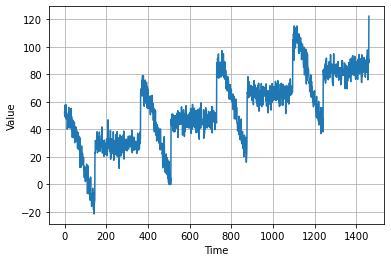

In [4]:
plot_series(time, series, format="-", start=0, end=len(time))

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  #dataset = tf.expand_dims(series, axis=-1) # You can also do it here
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 42ms/step - loss: 195.5726 - mae: 196.0726 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 194.7819 - mae: 195.2819 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 193.5109 - mae: 194.0109 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 191.9080 - mae: 192.4080 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 190.0235 - mae: 190.5235 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 187.8582 - mae: 188.3582 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 185.3786 - mae: 185.8786 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 182.5483 - mae: 183.0483 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 179.3126 - mae: 179.8126

8/8 [==============================] - 0s 6ms/step - loss: 11.8291 - mae: 12.3227 - lr: 4.4668e-05
Epoch 75/100
8/8 [==============================] - 0s 6ms/step - loss: 8.9989 - mae: 9.4913 - lr: 5.0119e-05
Epoch 76/100
8/8 [==============================] - 0s 6ms/step - loss: 10.1840 - mae: 10.6727 - lr: 5.6234e-05
Epoch 77/100
8/8 [==============================] - 0s 7ms/step - loss: 14.5687 - mae: 15.0634 - lr: 6.3096e-05
Epoch 78/100
8/8 [==============================] - 0s 7ms/step - loss: 15.7551 - mae: 16.2510 - lr: 7.0795e-05
Epoch 79/100
8/8 [==============================] - 0s 6ms/step - loss: 13.7657 - mae: 14.2585 - lr: 7.9433e-05
Epoch 80/100
8/8 [==============================] - 0s 6ms/step - loss: 9.7294 - mae: 10.2192 - lr: 8.9125e-05
Epoch 81/100
8/8 [==============================] - 0s 7ms/step - loss: 17.9316 - mae: 18.4289 - lr: 1.0000e-04
Epoch 82/100
8/8 [==============================] - 0s 6ms/step - loss: 21.3375 - mae: 21.8337 - lr: 1.1220e-04
Epoch 83

In [7]:
model.input_shape

(None, None)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 40)          1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [9]:
for x,y in train_set:
  print("x size = ", np.shape(x.numpy()))
  print("y size = ", np.shape(y.numpy()))

x size =  (128, 20)
y size =  (128,)
x size =  (128, 20)
y size =  (128,)
x size =  (128, 20)
y size =  (128,)
x size =  (128, 20)
y size =  (128,)
x size =  (128, 20)
y size =  (128,)
x size =  (128, 20)
y size =  (128,)
x size =  (128, 20)
y size =  (128,)
x size =  (84, 20)
y size =  (84,)


(1e-08, 0.0001, 0.0, 30.0)

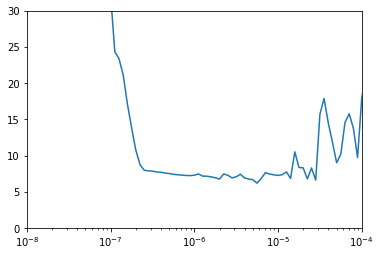

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 9ms/step - loss: 81.7535 - mae: 82.2535
Epoch 2/400
8/8 [==============================] - 0s 6ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 6ms/step - loss: 15.9199 - mae: 16.4142
Epoch 4/400
8/8 [==============================] - 0s 6ms/step - loss: 12.2876 - mae: 12.7811
Epoch 5/400
8/8 [==============================] - 0s 6ms/step - loss: 10.1462 - mae: 10.6363
Epoch 6/400
8/8 [==============================] - 0s 9ms/step - loss: 16.7771 - mae: 17.2714
Epoch 7/400
8/8 [==============================] - 0s 5ms/step - loss: 14.0516 - mae: 14.5450
Epoch 8/400
8/8 [==============================] - 0s 5ms/step - loss: 9.1673 - mae: 9.6583
Epoch 9/400
8/8 [==============================] - 0s 6ms/step - loss: 7.5296 - mae: 8.0125
Epoch 10/400
8/8 [==============================] - 0s 6ms/step - loss: 10.1465 - mae: 10.6336
Epoch 11/400
8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 8ms/step - loss: 4.8314 - mae: 5.3121
Epoch 89/400
8/8 [==============================] - 0s 5ms/step - loss: 4.5525 - mae: 5.0305
Epoch 90/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6033 - mae: 5.0779
Epoch 91/400
8/8 [==============================] - 0s 6ms/step - loss: 5.9644 - mae: 6.4442
Epoch 92/400
8/8 [==============================] - 0s 6ms/step - loss: 5.2581 - mae: 5.7408
Epoch 93/400
8/8 [==============================] - 0s 6ms/step - loss: 5.1682 - mae: 5.6467
Epoch 94/400
8/8 [==============================] - 0s 6ms/step - loss: 5.6392 - mae: 6.1191
Epoch 95/400
8/8 [==============================] - 0s 6ms/step - loss: 8.7759 - mae: 9.2644
Epoch 96/400
8/8 [==============================] - 0s 6ms/step - loss: 6.7968 - mae: 7.2814
Epoch 97/400
8/8 [==============================] - 0s 6ms/step - loss: 5.9922 - mae: 6.4773
Epoch 98/400
8/8 [==============================] - 0s 5ms/step - loss: 5.1787 - ma

8/8 [==============================] - 0s 5ms/step - loss: 4.6002 - mae: 5.0738
Epoch 176/400
8/8 [==============================] - 0s 5ms/step - loss: 4.7154 - mae: 5.1948
Epoch 177/400
8/8 [==============================] - 0s 5ms/step - loss: 5.1684 - mae: 5.6512
Epoch 178/400
8/8 [==============================] - 0s 5ms/step - loss: 4.7460 - mae: 5.2261
Epoch 179/400
8/8 [==============================] - 0s 5ms/step - loss: 5.0663 - mae: 5.5490
Epoch 180/400
8/8 [==============================] - 0s 7ms/step - loss: 4.7257 - mae: 5.2021
Epoch 181/400
8/8 [==============================] - 0s 6ms/step - loss: 4.7361 - mae: 5.2103
Epoch 182/400
8/8 [==============================] - 0s 6ms/step - loss: 4.4567 - mae: 4.9303
Epoch 183/400
8/8 [==============================] - 0s 6ms/step - loss: 4.8479 - mae: 5.3271
Epoch 184/400
8/8 [==============================] - 0s 6ms/step - loss: 5.1652 - mae: 5.6408
Epoch 185/400
8/8 [==============================] - 0s 6ms/step - loss: 5

8/8 [==============================] - 0s 5ms/step - loss: 4.3992 - mae: 4.8730
Epoch 263/400
8/8 [==============================] - 0s 6ms/step - loss: 4.4565 - mae: 4.9339
Epoch 264/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6791 - mae: 5.1591
Epoch 265/400
8/8 [==============================] - 0s 5ms/step - loss: 5.2213 - mae: 5.6998
Epoch 266/400
8/8 [==============================] - 0s 6ms/step - loss: 4.9653 - mae: 5.4439
Epoch 267/400
8/8 [==============================] - 0s 6ms/step - loss: 4.5691 - mae: 5.0479
Epoch 268/400
8/8 [==============================] - 0s 6ms/step - loss: 4.1448 - mae: 4.6184
Epoch 269/400
8/8 [==============================] - 0s 5ms/step - loss: 4.6250 - mae: 5.1002
Epoch 270/400
8/8 [==============================] - 0s 6ms/step - loss: 4.9386 - mae: 5.4180
Epoch 271/400
8/8 [==============================] - 0s 5ms/step - loss: 4.8889 - mae: 5.3658
Epoch 272/400
8/8 [==============================] - 0s 5ms/step - loss: 4

8/8 [==============================] - 0s 6ms/step - loss: 4.3540 - mae: 4.8301
Epoch 350/400
8/8 [==============================] - 0s 6ms/step - loss: 4.8906 - mae: 5.3691
Epoch 351/400
8/8 [==============================] - 0s 6ms/step - loss: 5.4648 - mae: 5.9454
Epoch 352/400
8/8 [==============================] - 0s 7ms/step - loss: 4.6622 - mae: 5.1396
Epoch 353/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3888 - mae: 4.8658
Epoch 354/400
8/8 [==============================] - 0s 5ms/step - loss: 4.5323 - mae: 5.0085
Epoch 355/400
8/8 [==============================] - 0s 6ms/step - loss: 6.5913 - mae: 7.0767
Epoch 356/400
8/8 [==============================] - 0s 6ms/step - loss: 7.1575 - mae: 7.6458
Epoch 357/400
8/8 [==============================] - 0s 6ms/step - loss: 6.2251 - mae: 6.7091
Epoch 358/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3914 - mae: 4.8641
Epoch 359/400
8/8 [==============================] - 0s 6ms/step - loss: 4

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


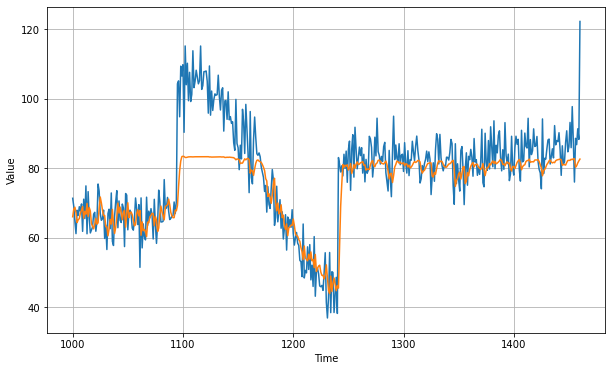

In [12]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.603156

<Figure size 432x288 with 0 Axes>

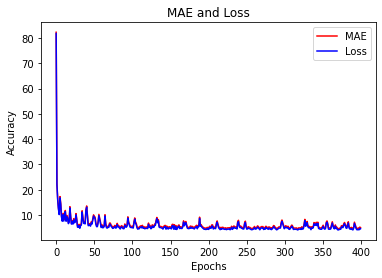

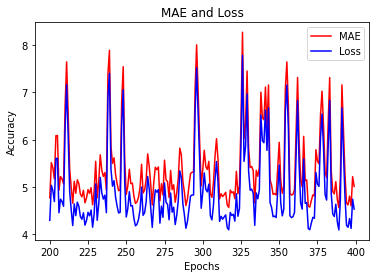

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()